# Notebook for assignment Responsible AI predictive XAI exercise

In [155]:
import os
import matplotlib.pyplot as plt
import torchvision
import torch
import pandas as pd
import numpy as np

from utils.notebook import display_scrollable_dataframe, plot_sailency
from data_loaders import CUB_extnded_dataset
from models import get_inception_transform
from IPython.display import display

from sailency import get_saliency_maps,saliency_score_part
%load_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [156]:
# Settings for the experiment your running
data_set = 'val' 

id = 222 # The id of the image you want to explain
#263 for the male bird



# Settings for loading the dataset, make sure its the same as the one used to train the model. 
# You can find the settings in the .hydra folders config.yaml 
data_config = {'CUB_dir':r'data/CUB_200_2011',
                'split_file':r'data_old/train_test_val.pkl',
                'use_majority_voting':False,
                'min_class_count':10,
                'return_visibility':True}



In [157]:
#Define data set, the human transformer data_set is used to get the original images instead of the normalized ones
transformer = get_inception_transform(mode='val',methode="center")
human_tansform = torchvision.transforms.Compose([torchvision.transforms.CenterCrop(299),torchvision.transforms.ToTensor()])

#Get dataset
data = CUB_extnded_dataset(mode=data_set,config_dict=data_config,transform=transformer)

#Get a dataset that return original images instead normalized ones
data_human = CUB_extnded_dataset(mode=data_set,config_dict=data_config,transform=human_tansform)
concept_names = data.consept_labels_names
class_names = data.class_labels_names
n_classes = data.n_classes
n_concepts = data.n_concepts

In [158]:

X, C, Y,coordinates = data.__getitem__(id)

print("Image shape: ",X.shape)
print("Concept shape: ",C.shape)
print("Label shape: ",Y.shape)   #there are 200 labels (that was the dimension mistake in the other code) why 
X = X.unsqueeze(0)

img ,_,_,_ = data_human.__getitem__(id)

print(Y.argmax())
print(Y) #are there 200 classes

Image shape:  torch.Size([3, 299, 299])
Concept shape:  torch.Size([2, 312])
Label shape:  torch.Size([200])
tensor(157)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [159]:
# Separate the concepts and their visibility only relevant if visibility is used and no majority voting is used
if len(C.shape) == 2:
    Concepts = C[0]
    Concepts_visiblity = C[1]
else:
    Concepts = C.tolist()
    Concepts_visiblity = [None]*len(C)

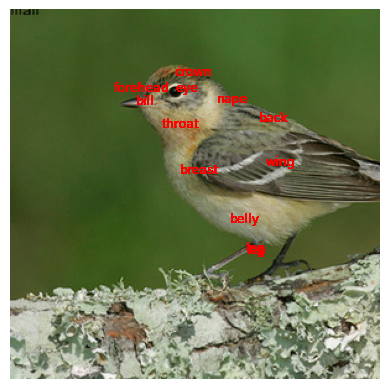

In [160]:
# Show the image and the coordinates of the concepts
plt.imshow(img.permute(1, 2, 0))

for i in range(len(coordinates)):
    if len(coordinates[i]) > 0:
        #print(f'coordinates {coordinates[i]} atribute_locations_names {consept_labels_masked[i]}')
        for x,y in coordinates[i]:
            #plt.plot(x,y,'ro')
            name=concept_names[i].split("_")[1]
            if name == "forehead":
                ofset = -30

            elif name == "eye":
                ofset = 0
            else:
                ofset = 0
            
            plt.text(x+ofset,y,name,fontsize=9,color='red')
    plt.axis('off')
            
plt.size=(50,50)
plt.show()

# Expandability for Sequential and independent models.  

In [161]:
#Load models make sure the model is trained with the same settings as the data loader
model_folder = r"models\Sequential_Basemodel2"   #3 er med og 2 er uden

X_to_C_path = os.path.join(model_folder,"best_XtoC_model.pth")
C_to_Y_path = os.path.join(model_folder,"best_CtoY_model.pth")

ModelXtoC = torch.load(X_to_C_path,map_location=torch.device('cpu'))
ModelCtoY = torch.load(C_to_Y_path,map_location=torch.device('cpu'))

In [162]:
#Make prediction

C_hat = ModelXtoC(X) #X is the image, C_hat is the concept prediction
Y_hat = ModelCtoY(C_hat) 

print(f"Predicted class: {Y_hat.argmax().item()} true class: {Y.argmax().item()} probability of true class: {Y_hat[0,Y.argmax()].item()}")

Predicted class: 68 true class: 157 probability of true class: 6.615666734433034e-07


In [163]:
#Make Concept prediction and other stuff
weights = ModelCtoY.linear.weight[Y.argmax().item()] #Find the weigths of the bird you guessed on.
Concept_frame = pd.DataFrame({"Concept":concept_names,"Concept_true":Concepts,"Concept_visiblity":Concepts_visiblity,"Concept_pred":np.round(C_hat[0].detach().numpy(),2),"CtoY_weight":weights.detach().numpy()})
display_scrollable_dataframe(Concept_frame)

,Concept,Concept_true,Concept_visiblity,Concept_pred,CtoY_weight
0,has_bill_shape::curved_(up_or_down),0.0,4.0,0.07,-0.003630
1,has_bill_shape::dagger,0.0,4.0,0.00,-0.023208
2,has_bill_shape::hooked,0.0,4.0,0.01,-0.003719
3,has_bill_shape::needle,0.0,4.0,0.25,-0.002985
4,has_bill_shape::hooked_seabird,0.0,4.0,0.00,-0.012556
5,has_bill_shape::spatulate,0.0,4.0,0.00,-0.008258
6,has_bill_shape::all-purpose,0.0,4.0,0.67,-0.049676
7,has_bill_shape::cone,1.0,4.0,0.99,-0.033531
8,has_bill_shape::specialized,0.0,4.0,0.00,-0.000750
9,has_wing_color::blue,0.0,4.0,0.06,-0.004767


In [128]:
def plot_sailency(img,sailency_map,concept_ids,concept_names,coordinates=None):
    """
    Plot the sailency map and the coordinates on the image
    args: img: torch.tensor: The image
    sailency_map: list of np.array: The sailency maps
    concept_ids: list of int: List of concepts that need to be plotted (somewhere between 1 and 5)
    concept_names: list of str: The names of the concepts
    coordinates: list of list of tuples: The coordinates to plot
    """

    num_pictures = len(concept_ids)+1
    fig, ax = plt.subplots(1, num_pictures, figsize=(10*num_pictures, 10))
    
    #Plot original image
    ax[0].imshow(img.permute(1, 2, 0))
    ax[0].set_title("Original image")

    for i,concept_id in enumerate(concept_ids):
        #Plot sailency map
        ax[i+1].imshow(sailency_map[i],cmap="jet")
        ax[i+1].set_title(concept_names[concept_id])
        ax[i+1].axis('off')

        #Plot coordinates
        if coordinates is not None:
            for x,y in coordinates[concept_id]:
                ax[i+1].plot(x,y,'ro')
            if len(coordinates[concept_id]) > 0:
                score = saliency_score_part(sailency_map[i],coordinates[concept_id])
                ax[i+1].set_title(f"{concept_names[concept_id]} Saliency score: {score:.2f}")

    plt.show()

In [111]:
from matplotlib.colors import LinearSegmentedColormap
default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

In [154]:
print(np.max(sailency_maps[1])) 

1.0030926e-06


In [164]:
def plot_sailency(img,sailency_map,concept_ids,concept_names,coordinates=None):
    """
    Plot the sailency map and the coordinates on the image
    args: img: torch.tensor: The image
    sailency_map: list of np.array: The sailency maps
    concept_ids: list of int: List of concepts that need to be plotted (somewhere between 1 and 5)
    concept_names: list of str: The names of the concepts
    coordinates: list of list of tuples: The coordinates to plot
    """

    num_pictures = len(concept_ids)+1
    fig, ax = plt.subplots(1, num_pictures, figsize=(10*num_pictures, 10))
    
    #Plot original image
    ax[0].imshow(img.permute(1, 2, 0))
    ax[0].set_title("Original image")

    for i,concept_id in enumerate(concept_ids):
        #Plot sailency map
        ax[i+1].imshow(sailency_map[i],cmap='Greens')
        ax[i+1].set_title(concept_names[concept_id])

        #Plot coordinates
        if coordinates is not None:
            for x,y in coordinates[concept_id]:
                ax[i+1].plot(x,y,'ro')
            if len(coordinates[concept_id]) > 0:
                score = saliency_score_part(sailency_map[i],coordinates[concept_id])
                ax[i+1].set_title(f"{concept_names[concept_id]} Saliency score: {score:.2f}")
    plt.savefig("male_without_maj")
    plt.show()

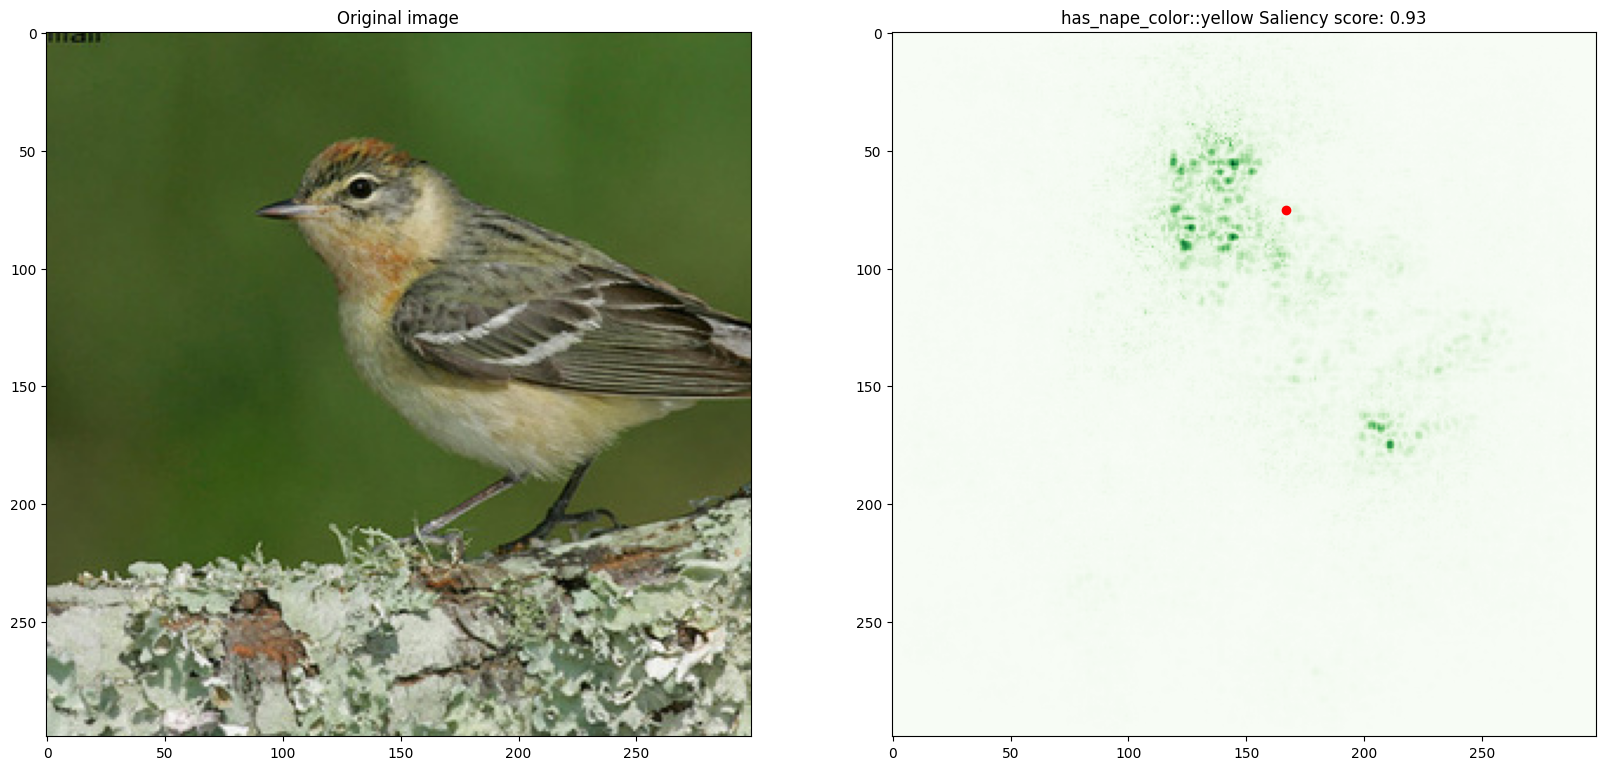

In [165]:
#List of concepts to plot
concept_list = [0,1,2,3,4,5]#list(range(10)) #why is it defined as this
concept_list = [10,20,30]#list(range(10)) #why is it defined as this
concept_list = [40,50,60,70,80]
concept_list = [188]

sailency_maps = get_saliency_maps_old(X,concept_list,ModelXtoC,method_type="vanilla")


plot_sailency(img,sailency_maps,concept_list,concept_names,coordinates)



<Figure size 640x480 with 0 Axes>

In [41]:
print(len(sailency_maps))

0


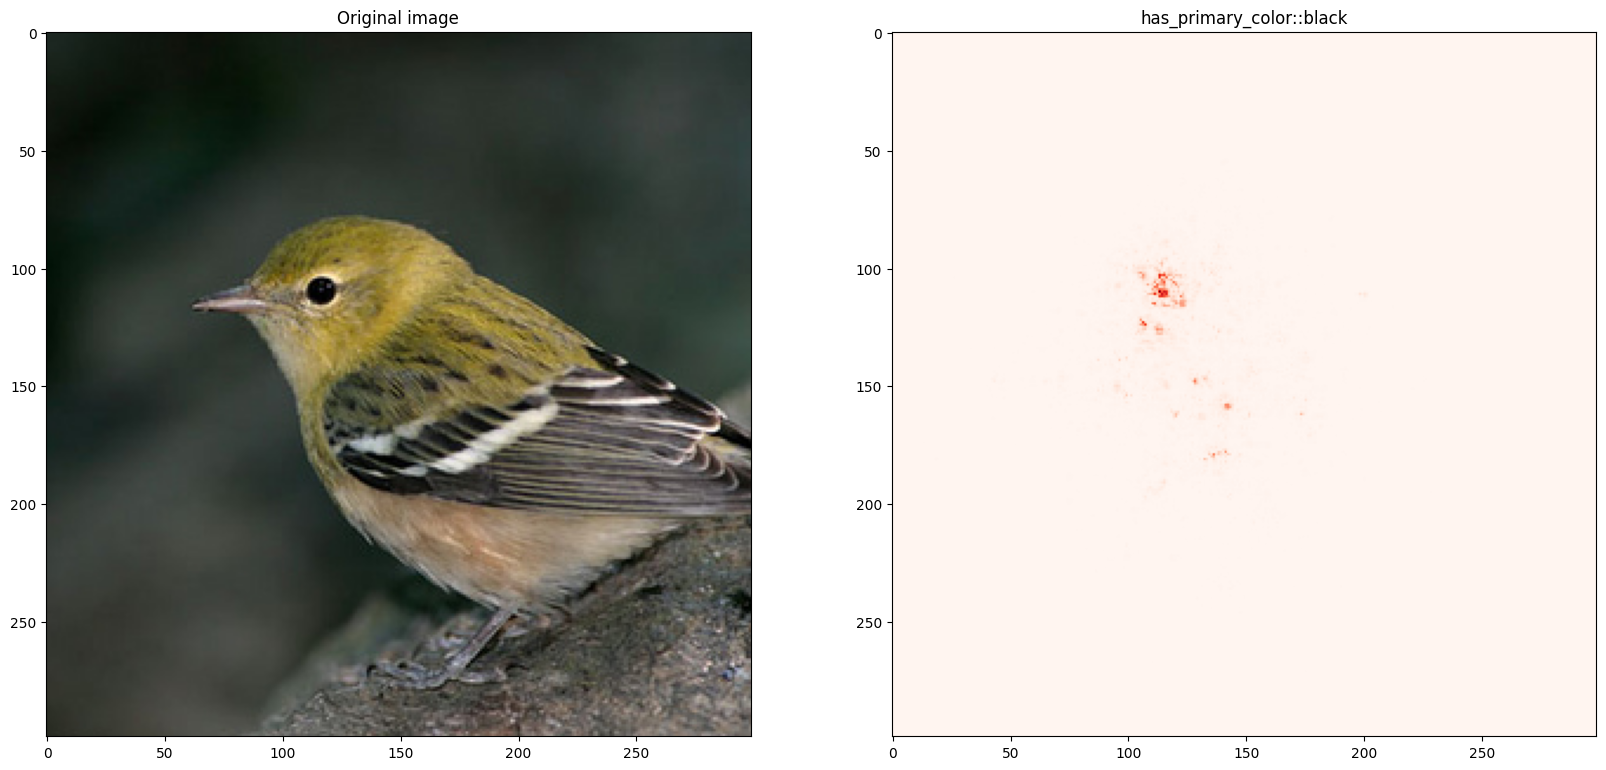

In [101]:

sailency_maps = get_saliency_maps_grad_cam(X,concept_list,ModelXtoC)


plot_sailency(img,sailency_maps,concept_list,concept_names,coordinates)

In [39]:
print(len(sailency_maps[0]))

299


### next up, agree with the girls on what dataset to run, calculate the mean of the concepts (with and without )


In [174]:
len(sailency_maps[0])

3

In [ ]:
score = saliency_score_part(sailency_map[i],coordinates[concept_id])


In [165]:
concept_list

[40, 50, 60, 70, 80]

In [26]:
import torch.nn.functional as F

def get_resized_saliency_map(gradcam_map, target_size):
    """
    Resize GradCAM output to match the original image size
    """
    # gradcam_map should have shape [1, 1, H, W] - the GradCAM output
    # target_size should be (299, 299) for your original image size
    resized_map = F.interpolate(gradcam_map, size=target_size, mode='bilinear', align_corners=False)
    
    return resized_map.squeeze().cpu().detach().numpy()  # Remove batch and channel dimensions

def get_saliency_maps(img, target_classes, model, method_type='vanilla'):
    img.requires_grad_(True)
    saliency_maps = []
    
    if method_type == 'vanilla':
        saliency = Saliency(model)
    elif method_type == 'gradcam':
        layer = model.model.Conv2d_2b_3x3
        saliency = LayerGradCam(model, layer)
    else:
        raise ValueError("Invalid method_type.")

    for target_class in target_classes:
        if method_type == 'vanilla':
            attribution = saliency.attribute(img, target=target_class, abs=True)
            
        elif method_type == 'gradcam':
            attribution = saliency.attribute(img, target=target_class)
            attribution = torch.max(attribution, dim=1, keepdim=True)

            # Resize GradCAM output to match the original input size
            attribution = get_resized_saliency_map(attribution, (299, 299))

        # Normalize and append to the list
        if np.max(attribution) != 0:
            attribution = attribution / np.sum(attribution)  # Normalize to sum to 1
        saliency_maps.append(attribution)

    return saliency_maps



def get_saliency_maps_grad_cam(img, target_classes, model):


    img.requires_grad_(True)
    saliency_maps = []
    

    saliency = Saliency(model)


    for target_class in target_classes:

        attribution = NoiseTunnel(saliency).attribute(img, nt_type='smoothgrad_sq', nt_samples=10, stdevs=0.2, target=target_class)

        #attribution = torch.max(attribution, dim=1, keepdim=True)

        # Resize GradCAM output to match the original input size

        # Normalize and append to the list
        #if np.max(attribution) != 0:
        #    attribution = attribution / np.sum(attribution)  # Normalize to sum to 1

        result = attribution.squeeze().cpu().detach().numpy()
        mean_result = result.sum(axis=0)


        saliency_maps.append(mean_result)


    return saliency_maps

In [100]:
def get_saliency_maps_chat(img, target_classes, model, method_type='vanilla'):
    img.requires_grad_(True)
    saliency_maps = []
    
    if method_type == 'vanilla':
        saliency = Saliency(model)
    elif method_type == 'gradcam':
        layer = model.model.Conv2d_2b_3x3
        saliency = LayerGradCam(model, layer)
    else:
        raise ValueError("Invalid method_type.")

    for target_class in target_classes:
        if method_type == 'vanilla':
            attribution = saliency.attribute(img, target=target_class, abs=True)
        elif method_type == 'gradcam':
            print(img.shape)
            attribution = saliency.attribute(img, target=target_class)
            attribution = torch.mean(attribution, dim=1, keepdim=True)
            print("Did it",attribution.shape)

        map = attribution.squeeze().cpu().detach().numpy().sum(axis=0)
        print(len(map))
        if np.max(map) != 0:
            map = map / np.sum(map)
        saliency_maps.append(map)

    print("You get here")
    print(len(saliency_maps[0]))

    return saliency_maps


In [27]:


def get_saliency_maps_old(img, target_classes,model, method_type='vanilla'):
    

    """
    Function to compute saliency maps for a given image and a list of classes.


    Args:
        img (torch.Tensor): Input image tensor of shape (C, H, W).
        target_classes (List[int]): List of target classes for which to compute saliency maps.
        model (torch.nn.Module): The model for which to compute saliency maps.
        method_type (str): The method to use for computing saliency maps. Options: 'vanilla', 'noise_tunnel', 'gradcam'.
                           Default is 'vanilla'.
    """
    


    # Load and preprocess the image
    img.requires_grad_(True)



    # Initialize the appropriate method
    if method_type == 'vanilla':
        saliency = Saliency(model)
    


    elif method_type == 'noise_tunnel':
        saliency = NoiseTunnel(Saliency(model))
    


    elif method_type == 'gradcam':
        #layer = model.model.Conv2d_2b_3x3
        #saliency = LayerGradCam(model, layer)
        saliency = Saliency(model)

    

    else:
        raise ValueError("Invalid method_type. Choose from 'vanilla', 'noise_tunnel', or 'gradcam'.")


    # Create a batch by repeating the input image
    batched_input = img.repeat(len(target_classes), 1, 1, 1)


    if method_type == 'vanilla':
        # Compute vanilla saliency
        attribution = saliency.attribute(batched_input, target=target_classes,abs=True)
    

    # Loop over all the target classes
    #for target_class in target_classes:
    

    elif method_type == 'noise_tunnel':
            # Compute saliency with noise tunneling
         attribution = saliency.attribute(img, target=target_classes, nt_type='smoothgrad', nt_samples=50, stdevs=0.2)
    


    #TODO fingure out how to get gradcam to work with inception
    elif method_type == 'gradcam':
        # Compute GradCAM
        print("You get here")
        attribution = saliency.attribute(img, target=target_classes)
        attribution = torch.mean(attribution, dim=1, keepdim=True)  # Average across channels
    

    saliency_maps = []
    for map in attribution:
        map = map.squeeze().cpu().detach().numpy().sum(axis=0)  # Convert attribution to numpy array and sum across channels
        if np.max(map) != 0:
            map = map / np.sum(map)  # Normalize to sum to 1        
            saliency_maps.append(map)  



    return saliency_maps

In [29]:
import numpy as np
import torch
from captum.attr import Saliency, NoiseTunnel, LayerGradCam

def get_saliency_maps(img, target_classes, model, method_type='vanilla'):
    """
    Function to compute saliency maps for a given image and a list of classes.

    Args:
        img (torch.Tensor): Input image tensor of shape (C, H, W).
        target_classes (List[int]): List of target classes for which to compute saliency maps.
        model (torch.nn.Module): The model for which to compute saliency maps.
        method_type (str): The method to use for computing saliency maps. Options: 'vanilla', 'noise_tunnel', 'gradcam'.
                           Default is 'vanilla'.
    """
    img.requires_grad_(True)

    if method_type == 'vanilla':
        saliency = Saliency(model)
    elif method_type == 'noise_tunnel':
        saliency = NoiseTunnel(Saliency(model))
    elif method_type == 'gradcam':
        layer = model.model.Conv2d_2b_3x3  # Adjust this layer to match your model architecture
        saliency = LayerGradCam(model, layer)
    else:
        raise ValueError("Invalid method_type. Choose from 'vanilla', 'noise_tunnel', or 'gradcam'.")

    batched_input = img.repeat(len(target_classes), 1, 1, 1)

    if method_type in ['vanilla', 'noise_tunnel']:
        attribution = saliency.attribute(batched_input, target=target_classes, abs=True)
    elif method_type == 'gradcam':
        attribution = torch.stack([
            saliency.attribute(batched_input[i].unsqueeze(0), target=target_classes[i])
            for i in range(len(target_classes))
        ])
        attribution = torch.mean(attribution, dim=1)  # Remove `keepdim=True` to avoid extra dimensions

    # Process and normalize each map
    saliency_maps = []
    for map in attribution:
        map = map.squeeze().cpu().detach().numpy()  # Ensure this is 2D
        if np.max(map) != 0:
            map = map / np.max(map)  # Normalize each map
        saliency_maps.append(map)

    return saliency_maps


In [57]:
import numpy as np
import torch
from captum.attr import Saliency, NoiseTunnel, LayerGradCam

def get_saliency_maps(img, target_classes, model, method_type='vanilla'):
    """
    Function to compute saliency maps for a given image and a list of classes.

    Args:
        img (torch.Tensor): Input image tensor of shape (C, H, W).
        target_classes (List[int]): List of target classes for which to compute saliency maps.
        model (torch.nn.Module): The model for which to compute saliency maps.
        method_type (str): The method to use for computing saliency maps. Options: 'vanilla', 'noise_tunnel', 'gradcam'.
                           Default is 'vanilla'.
    """
    print("Yess")
    # Ensure img tensor requires gradient for saliency computation
    img.requires_grad_(True)

    # Initialize the appropriate method for saliency
    if method_type == 'vanilla':
        saliency = Saliency(model)
    elif method_type == 'noise_tunnel':
        saliency = NoiseTunnel(Saliency(model))
    elif method_type == 'gradcam':
        layer = model.model.Conv2d_2b_3x3  # Adjust layer to specific model architecture
        saliency = LayerGradCam(model, layer)
    else:
        raise ValueError("Invalid method_type. Choose from 'vanilla', 'noise_tunnel', or 'gradcam'.")

    # Repeat the image for batch processing across target classes
    batched_input = img.repeat(len(target_classes), 1, 1, 1)

    # Calculate saliency or attribution based on method type
    if method_type in ['vanilla', 'noise_tunnel']:
        # Vanilla or noise tunnel saliency
        attribution = saliency.attribute(batched_input, target=target_classes, abs=True)
    elif method_type == 'gradcam':
        # GradCAM saliency
        attribution = torch.stack([saliency.attribute(batched_input[i].unsqueeze(0), target=target_classes[i]) 
                                   for i in range(len(target_classes))])
        attribution = torch.mean(attribution, dim=1, keepdim=True)  # Average across channels

    # Convert the attributions to saliency maps
    saliency_maps = []
    for map in attribution:
        map = map.squeeze().cpu().detach().numpy().sum(axis=0)  # Sum across channels
        if np.max(map) != 0:
            map = map / np.sum(map)  # Normalize if max is non-zero
        saliency_maps.append(map)

    return saliency_maps


# Saliency map for Joint models  

In [11]:
#Load models make sure the model is trained with the same settings as the data loader
model_path = r'models\Seqeuntial_Basemodel1\best_Joint_model.pth'
#model_path = r'models\Joint_Basemodel3\best_Joint_model.pth'


n_classes = data.n_classes
n_concepts = data.n_concepts

#Load the model
Joint_model = torch.load(model_path,map_location=torch.device('cpu'))




C:\Users\Andre\AppData\Local\Temp\ipykernel_43036\961612813.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Joint_model = torch.load(model_path,map_location=torch.device

In [12]:
#Make prediction
C_hat,Y_hat = Joint_model(X)
print(f"Predicted class: {Y_hat.argmax().item()} true class: {Y.argmax().item()} probability of true class: {Y_hat[0,Y.argmax()].item()}")

Predicted class: 86 true class: 86 probability of true class: 0.5894005298614502


In [13]:
#Make Concept prediction and other stuff
weights = Joint_model.MLP_model.linear.weight[Y.argmax().item()]
Concept_frame = pd.DataFrame({"Concept":concept_names,"Concept_true":Concepts,"Concept_visiblity":Concepts_visiblity,"Concept_pred":np.round(C_hat[0].detach().numpy(),2),"CtoY_weight":weights.detach().numpy()})
display_scrollable_dataframe(Concept_frame)

,Concept,Concept_true,Concept_visiblity,Concept_pred,CtoY_weight
0,has_bill_shape::dagger,0.0,None,0.09,-0.097437
1,has_bill_shape::hooked_seabird,0.0,None,0.68,-0.074110
2,has_bill_shape::all-purpose,0.0,None,0.00,-0.123883
3,has_bill_shape::cone,0.0,None,0.00,-0.107772
4,has_wing_color::brown,0.0,None,0.00,-0.111161
5,has_wing_color::grey,0.0,None,0.97,-0.087807
6,has_wing_color::yellow,0.0,None,0.03,-0.024880
7,has_wing_color::black,0.0,None,0.03,-0.163443
8,has_wing_color::white,1.0,None,0.77,0.648769
9,has_wing_color::buff,0.0,None,0.02,-0.053578


In [9]:
concept_list = [51,50,111]

#Make model only predict the concept C
Joint_model.set_sailency_output("C")

sailency_maps = get_saliency_maps(X,concept_list,Joint_model,method_type="gradcam")

plot_sailency(img,sailency_maps,concept_list,concept_names,coordinates)

NameError: name 'Joint_model' is not defined

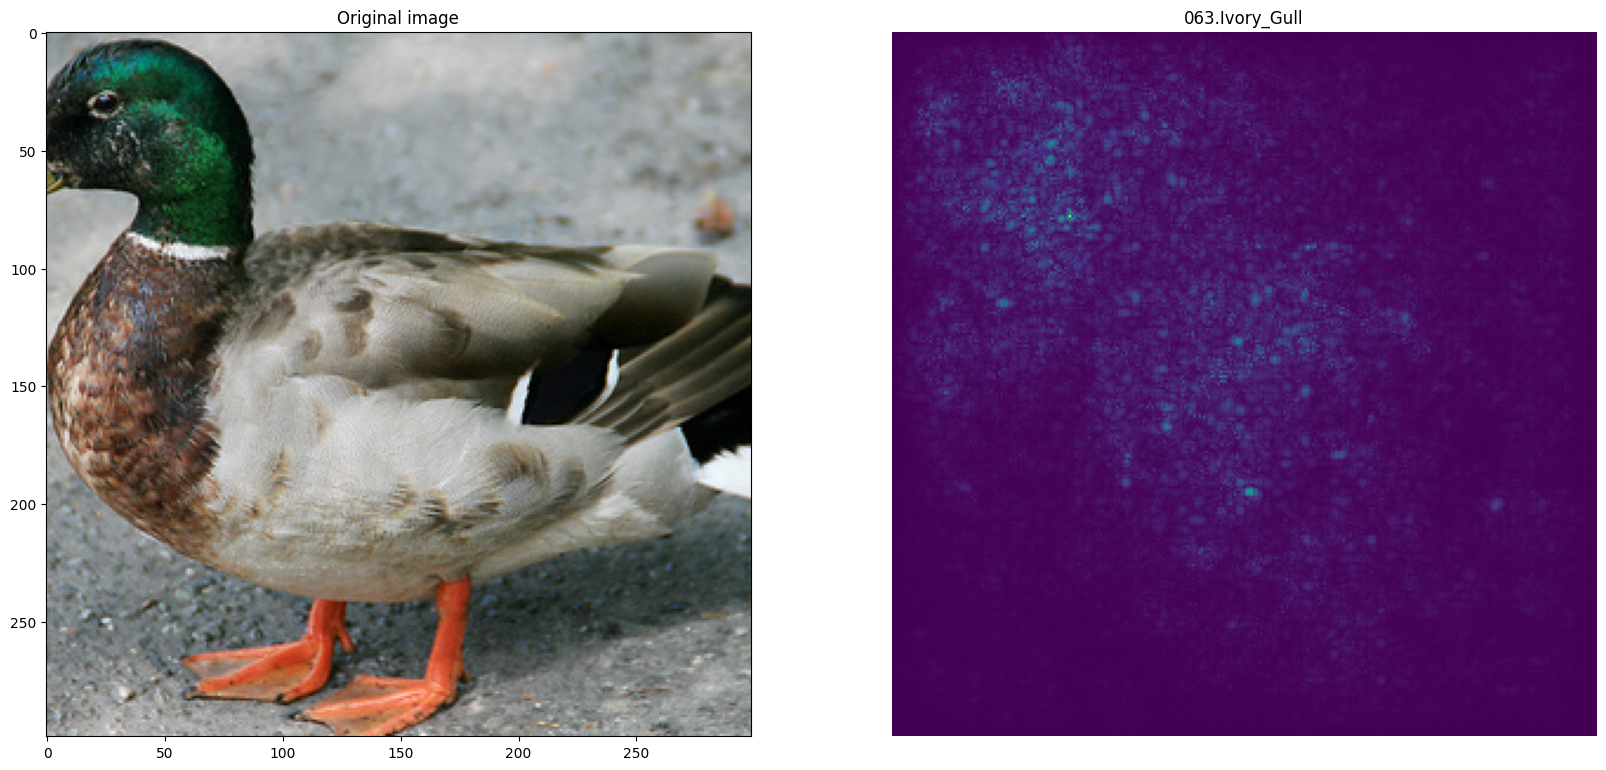

In [15]:
concept_list = [62]

#Make model only predict the concept C
Joint_model.set_sailency_output("Y")

sailency_maps = get_saliency_maps(X,concept_list,Joint_model,method_type="vanilla")

plot_sailency(img,sailency_maps,concept_list,class_names)